# Depth evaluation
Compare the accuracy and time required for the forecast for an increasing maximum tree depth.

**Algorithms**:
- Decision Tree
- Random forest
- XG Boost

## Preparation
- Imports
- Data preprocessing
- Feature and target encoding

In [1]:
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return 0
    elif row['days_until_trending'] == 1:
        return 1
    elif row['days_until_trending'] == 2:
        return 2
    elif row['days_until_trending'] <= 5:
        return 3
    else:
        return 6

df['target_category'] = df.apply(assign_target_category, axis=1)
df['channel_title'] = df['channel_title'].astype('category')

tag_df = pd.read_csv('../0_data/DEtags.csv')
tag_df = tag_df.set_index('tag')
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
    
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)

x_df = DataFrame(index=df.index)
features = ['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']
for feature in features:
    feature_data = df[feature]
    if df[feature].dtype.name == 'category':
        x_label_encoder = preprocessing.LabelEncoder()
        x_label_encoder.fit(feature_data.astype(str))
        x_df[feature] = x_label_encoder.transform(feature_data)
    elif df[feature].dtype.name == 'datetime64[ns]':
        x_df[feature] = feature_data.to_seconds()
    elif df[feature].dtype.name == 'bool':
        x_df[feature] = int(feature_data)
    else:
        x_df[feature] = feature_data

x = np.reshape(x_df, (-1, len(x_df.columns)))

target = df['target_category'].astype(str)
y_label_encoder = preprocessing.LabelEncoder()
y_label_encoder.fit(target)
y = y_label_encoder.transform(target)

In [2]:
%%time
dt_model = DecisionTreeClassifier()
optimization_dict = {'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50]}

model_dt = GridSearchCV(dt_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model_dt.fit(x,y)
print(model_dt.best_score_)
print(model_dt.best_params_)

0.6560479921645446
{'max_depth': 8}
Wall time: 3.05 s


In [3]:
results_dt = pd.DataFrame()
results_dt['mean_fit_time'] = model_dt.cv_results_.get('mean_fit_time')
results_dt['mean_score_time'] = model_dt.cv_results_.get('mean_score_time')
results_dt['params'] = model_dt.cv_results_.get('params')
results_dt['mean_test_score'] = model_dt.cv_results_.get('mean_test_score')
results_dt['rank_test_score'] = model_dt.cv_results_.get('rank_test_score')
results_dt['algorithm'] = 'decision_tree'

In [4]:
%%time
rf_model = RandomForestClassifier()
optimization_dict = {'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50]}

model_rf = GridSearchCV(rf_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model_rf.fit(x,y)
print(model_rf.best_score_)
print(model_rf.best_params_)

0.6896425073457395
{'max_depth': 20}
Wall time: 33.8 s


In [5]:
results_rf = pd.DataFrame()
results_rf['mean_fit_time'] = model_rf.cv_results_.get('mean_fit_time')
results_rf['mean_score_time'] = model_rf.cv_results_.get('mean_score_time')
results_rf['params'] = model_rf.cv_results_.get('params')
results_rf['mean_test_score'] = model_rf.cv_results_.get('mean_test_score')
results_rf['rank_test_score'] = model_rf.cv_results_.get('rank_test_score')
results_rf['algorithm'] = 'random_forest'

In [6]:
%%time
xgb_model = XGBClassifier(use_label_encoder=False, verbosity=0)
optimization_dict = {'max_depth': [None, 2, 4, 6, 8, 10, 25, 50]}

model_xgb = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model_xgb.fit(x,y)
print(model_xgb.best_score_)
print(model_xgb.best_params_)

0.6784280117531831
{'max_depth': None}
Wall time: 1min 46s


In [7]:
results_xgb = pd.DataFrame()
results_xgb['mean_fit_time'] = model_xgb.cv_results_.get('mean_fit_time')
results_xgb['mean_score_time'] = model_xgb.cv_results_.get('mean_score_time')
results_xgb['params'] = model_xgb.cv_results_.get('params')
results_xgb['mean_test_score'] = model_xgb.cv_results_.get('mean_test_score')
results_xgb['rank_test_score'] = model_xgb.cv_results_.get('rank_test_score')
results_xgb['algorithm'] = 'xg_boost'

In [8]:
results = results_dt.append(results_rf.append(results_xgb))
results['total_time'] = (results['mean_fit_time'] + results['mean_score_time'])
results['max_depth'] = results.apply(lambda row: -1 if row['params'].get('max_depth') == None else row['params'].get('max_depth'), axis=1)
results.head(15)

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score,algorithm,total_time,max_depth
0,0.289598,0.004201,{'max_depth': None},0.599559,11,decision_tree,0.293800,-1
1,0.046799,0.002200,{'max_depth': 2},0.623751,8,decision_tree,0.048999,2
2,0.086398,0.002803,{'max_depth': 4},0.636925,6,decision_tree,0.089201,4
3,0.121999,0.003200,{'max_depth': 6},0.645690,4,decision_tree,0.125199,6
4,0.149196,0.003200,{'max_depth': 8},0.656048,1,decision_tree,0.152397,8
5,0.175996,0.002801,{'max_depth': 10},0.654603,2,decision_tree,0.178797,10
6,0.227198,0.002999,{'max_depth': 12},0.648702,3,decision_tree,0.230197,12
7,0.241799,0.003401,{'max_depth': 14},0.640157,5,decision_tree,0.245200,14
8,0.228599,0.003600,{'max_depth': 16},0.626200,7,decision_tree,0.232199,16
9,0.247199,0.004000,{'max_depth': 18},0.618683,9,decision_tree,0.251200,18


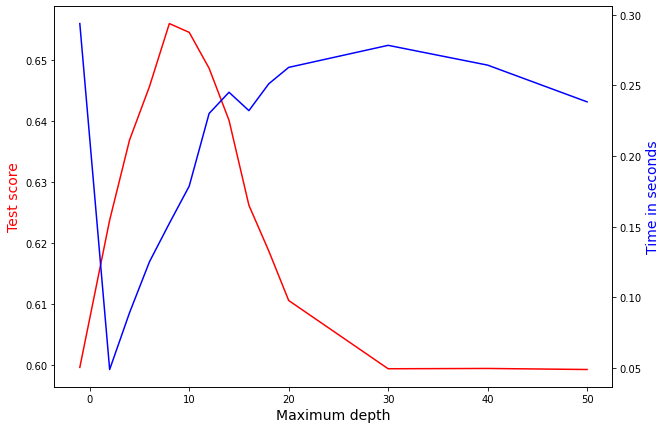

In [9]:
results_dt = results[results['algorithm'] == 'decision_tree']

fig,ax = plt.subplots()
ax.plot(results_dt.max_depth, results_dt.mean_test_score, color="red")
ax.set_xlabel("Maximum depth", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_dt.max_depth, results_dt.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

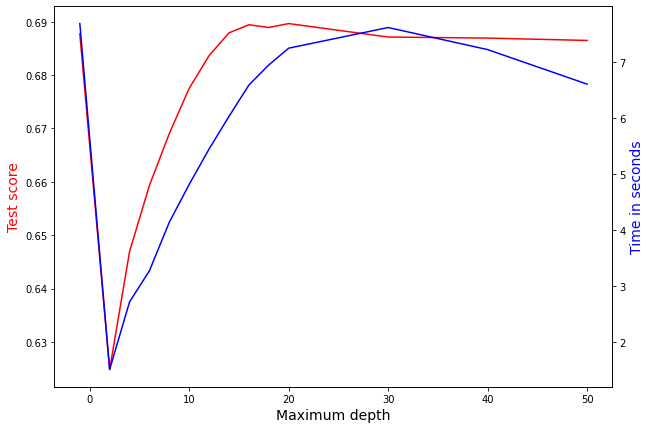

In [10]:
results_rf = results[results['algorithm'] == 'random_forest']

fig,ax = plt.subplots()
ax.plot(results_rf.max_depth, results_rf.mean_test_score, color="red")
ax.set_xlabel("Maximum depth", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_rf.max_depth, results_rf.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

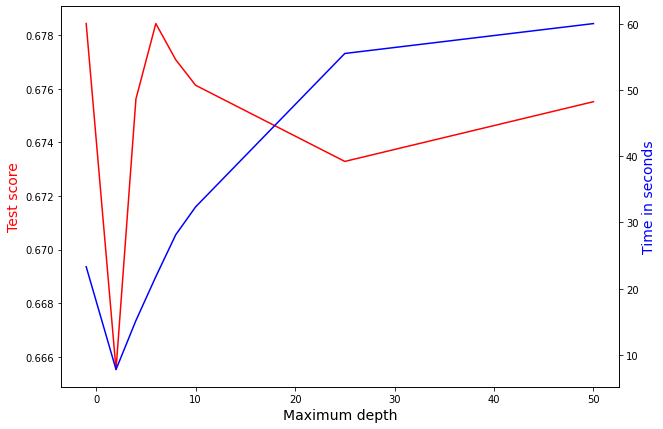

In [11]:
results_xgb = results[results['algorithm'] == 'xg_boost']

fig,ax = plt.subplots()
ax.plot(results_xgb.max_depth, results_xgb.mean_test_score, color="red")
ax.set_xlabel("Maximum depth", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_xgb.max_depth, results_xgb.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

<AxesSubplot:xlabel='max_depth', ylabel='mean_test_score'>

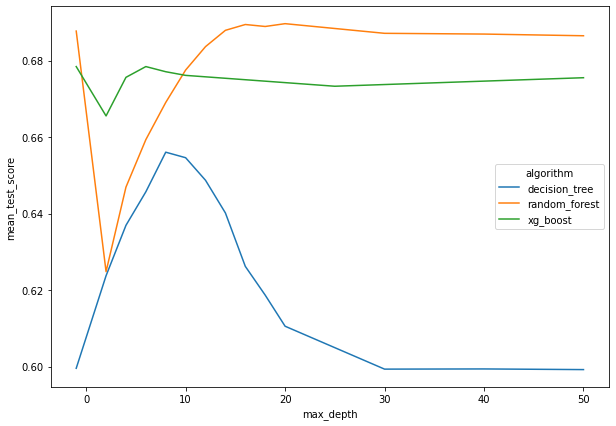

In [12]:
sns.lineplot(data=results, x='max_depth', y='mean_test_score', hue='algorithm')

<AxesSubplot:xlabel='max_depth', ylabel='total_time'>

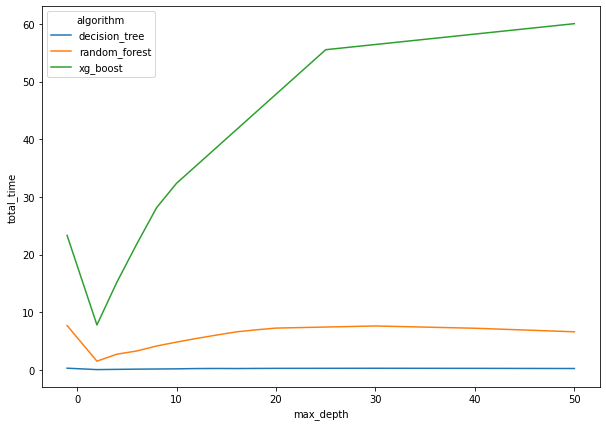

In [13]:
sns.lineplot(data=results, x='max_depth', y='total_time', hue='algorithm')